In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Paraná - Consumo de Cimento (t)'
start_index = 0
split_index = 155
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_PR.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Paraná- custo m2 (R$),Paraná - IDH Renda,Paraná - Depósito Poupança (R$),Paraná - Desemprego,Paraná - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraná - IDH Longevidade,Paraná - Produção de Cimento (t),Paraná - IDH Educacao,Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - PIB - Per Capita,Paraná - PIB - Preços de Mercado,Paraná - IDH,Paraná - Consumo de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,11767.370000,0.800130,1.312029e+07,8.284196,0.300568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.819425,332.705560,0.728728,2.027147e+08,1.060612e+07,17.589536,1.851788e+08,0.776871,189.804,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,11852.421538,0.799796,1.313619e+07,8.277973,0.301710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.819770,332.945945,0.729031,2.029477e+08,1.061597e+07,17.592548,1.852326e+08,0.776975,174.713,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,11934.318946,0.799462,1.315208e+07,8.271750,0.302645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820115,335.222130,0.729334,2.031806e+08,1.062582e+07,17.595559,1.852864e+08,0.777079,180.801,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,12015.342874,0.799128,1.316797e+07,8.265527,0.303413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820460,334.785737,0.729638,2.034136e+08,1.063567e+07,17.598570,1.853401e+08,0.777183,180.172,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,12093.451150,0.798794,1.318386e+07,8.259304,0.304034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820805,335.050185,0.729941,2.036466e+08,1.064551e+07,17.601581,1.853939e+08,0.777287,185.597,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,39310.840386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,39274.836083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,39220.898111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,39146.237796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


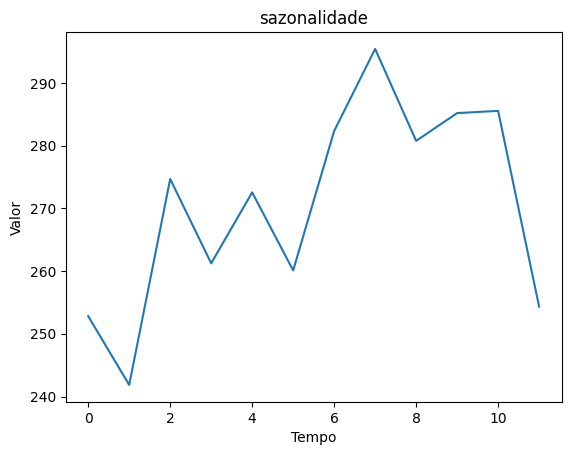

,sazonalidade
sazonalidade,
0,252.809177
1,241.847229
2,274.674791
3,261.239480
4,272.539740
5,260.100722
6,282.323976
7,295.416152
8,280.758044


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Paraná- custo m2 (R$),Paraná - IDH Renda,Paraná - Depósito Poupança (R$),Paraná - Desemprego,Paraná - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraná - IDH Longevidade,Paraná - Produção de Cimento (t),Paraná - IDH Educacao,Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - PIB - Per Capita,Paraná - PIB - Preços de Mercado,Paraná - IDH,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Paraná - Consumo de Cimento (t)
0,2003-1,11767.370000,0.800130,1.312029e+07,8.284196,0.300568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.819425,332.705560,0.728728,2.027147e+08,1.060612e+07,17.589536,1.851788e+08,0.776871,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,252.809177,189.804
1,2003-2,11852.421538,0.799796,1.313619e+07,8.277973,0.301710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.819770,332.945945,0.729031,2.029477e+08,1.061597e+07,17.592548,1.852326e+08,0.776975,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,241.847229,174.713
2,2003-3,11934.318946,0.799462,1.315208e+07,8.271750,0.302645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820115,335.222130,0.729334,2.031806e+08,1.062582e+07,17.595559,1.852864e+08,0.777079,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,274.674791,180.801
3,2003-4,12015.342874,0.799128,1.316797e+07,8.265527,0.303413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820460,334.785737,0.729638,2.034136e+08,1.063567e+07,17.598570,1.853401e+08,0.777183,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,261.239480,180.172
4,2003-5,12093.451150,0.798794,1.318386e+07,8.259304,0.304034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820805,335.050185,0.729941,2.036466e+08,1.064551e+07,17.601581,1.853939e+08,0.777287,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,272.539740,185.597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,39310.840386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,272.539740,NaN
245,2023-6,39274.836083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,260.100722,NaN
246,2023-7,39220.898111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,282.323976,NaN
247,2023-8,39146.237796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,295.416152,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      172.044
1      188.841
2      200.253
3      188.916
4      184.994
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: Paraná - Consumo de Cimento (t), Length: 249, dtype: float64

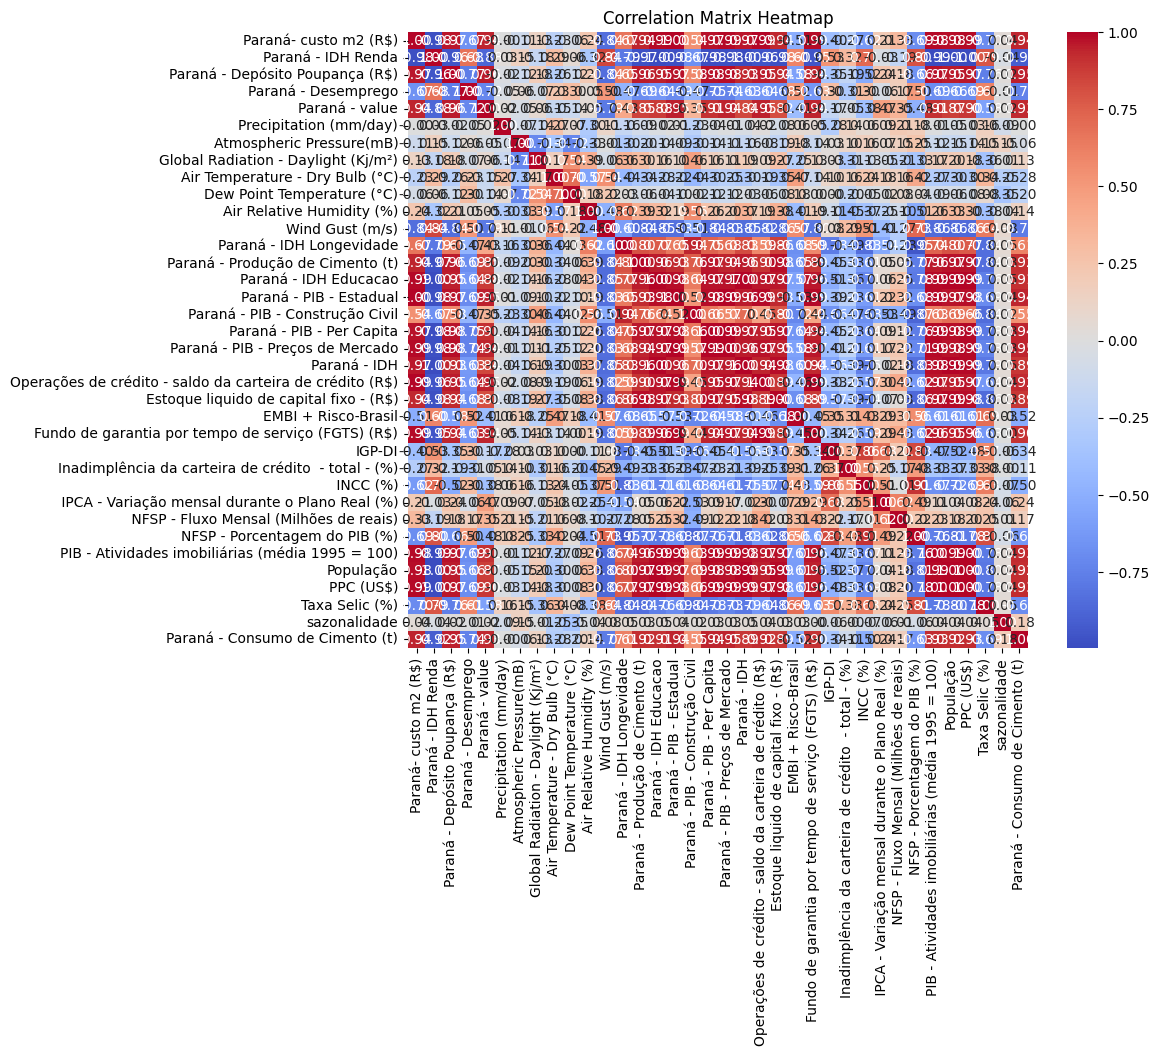

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.fillna(0.0).iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Paraná- custo m2 (R$),4.376157e+06
1,Paraná - IDH Renda,4.728408e+08
2,Paraná - Depósito Poupança (R$),6.578514e+05
3,Paraná - Desemprego,1.875755e+05
4,Paraná - value,2.064038e+05
5,Precipitation (mm/day),1.181473e+02
6,Atmospheric Pressure(mB),6.705209e+05
7,Global Radiation - Daylight (Kj/m²),2.047285e+03
8,Air Temperature - Dry Bulb (°C),4.357877e+05
9,Dew Point Temperature (°C),2.240076e+05


In [39]:
data =data.fillna(0.0).drop(['Air Temperature - Dry Bulb (°C)',
                 'Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 9


,Paraná- custo m2 (R$),Paraná - Depósito Poupança (R$),Paraná - Desemprego,Paraná - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraná - Produção de Cimento (t),Paraná - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,11767.370000,1.312029e+07,8.284196,0.300568,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,332.705560,1.060612e+07,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,252.809177
1,11852.421538,1.313619e+07,8.277973,0.301710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,332.945945,1.061597e+07,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,241.847229
2,11934.318946,1.315208e+07,8.271750,0.302645,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,335.222130,1.062582e+07,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,274.674791
3,12015.342874,1.316797e+07,8.265527,0.303413,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.785737,1.063567e+07,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,261.239480
4,12093.451150,1.318386e+07,8.259304,0.304034,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,335.050185,1.064551e+07,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,272.539740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,23931.908949,2.531292e+07,7.829249,0.428466,1.365853,913.187662,1071.568212,17.737212,13.226119,77.959636,1.871255,480.008857,1.103971e+07,3.143856e+06,336.843217,9.124085e+06,0.471500,3.103302,0.501878,0.527374,-1005.696691,2.438647,192.698092,390.589413,1.078474,295.416152
152,24020.236894,2.517430e+07,7.831533,0.424777,1.548454,912.398919,1055.279314,18.386401,14.262155,79.537000,1.953528,480.788160,1.103440e+07,3.159665e+06,345.939329,9.111628e+06,0.475422,3.177535,0.489257,0.525404,-1039.159506,2.375528,192.754385,391.798431,0.962516,280.758044
153,24108.392493,2.503569e+07,7.833817,0.420897,1.742854,911.987238,1087.895930,18.999770,15.058004,80.190935,2.035267,481.089267,1.102909e+07,3.177292e+06,356.198303,9.630300e+06,0.447600,3.254167,0.489071,0.522000,-1243.715598,2.307250,192.810678,393.032398,1.138989,285.184729
154,24197.846848,2.489707e+07,7.836101,0.417199,1.934099,911.579910,1113.914966,19.817226,15.877228,80.182396,2.047979,479.861209,1.102378e+07,3.192250e+06,363.318059,1.020613e+07,0.426394,3.330340,0.486059,0.509714,-1329.246736,2.242645,192.715004,394.326420,1.038436,285.539436


In [40]:
input_data = data.fillna(0.0).iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
input_data = input_data.fillna(0.0)
input_data

,Paraná - Depósito Poupança (R$),Paraná - Desemprego,Paraná - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraná - Produção de Cimento (t),Paraná - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.233769,1.017252,-0.798454,-2.601305,-3.464070,-3.296945,-3.225383,-3.162893,-3.323537,-2.982668,-1.495716,-2.313709,-1.219223,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.737578,2.007617
1,-1.230926,1.003893,-0.781100,-2.601305,-3.464070,-3.296945,-3.225383,-3.162893,-3.323537,-2.982668,-1.491699,-2.269464,-1.218580,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.724415,1.464013
2,-1.228083,0.990533,-0.766892,-2.601305,-3.464070,-3.296945,-3.225383,-3.162893,-3.323537,-2.982668,-1.453667,-2.225220,-1.218537,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.710831,2.880457
3,-1.225240,0.977174,-0.755220,-2.601305,-3.464070,-3.296945,-3.225383,-3.162893,-3.323537,-2.982668,-1.460959,-2.180975,-1.218044,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.696931,1.143128
4,-1.222397,0.963815,-0.745775,-2.601305,-3.464070,-3.296945,-3.225383,-3.162893,-3.323537,-2.982668,-1.456540,-2.136731,-1.216487,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0.947452,0.040584,1.145405,-0.179936,0.290056,-0.002811,0.145965,0.290084,0.463803,-0.203787,0.965528,-0.365689,1.823582,0.414233,1.659621,-0.661498,-0.418507,-1.258759,0.318154,2.562832,-0.538499,1.326731,1.398025,0.209123
152,0.922654,0.045487,1.089335,0.143777,0.286813,-0.052885,0.269358,0.560565,0.540433,-0.081609,0.978549,-0.389536,1.841017,0.494098,1.654471,-0.630482,-0.159821,-1.388696,0.293838,2.549126,-0.570093,1.329342,1.415152,-0.182135
153,0.897856,0.050391,1.030370,0.488406,0.285121,0.047382,0.385942,0.768339,0.572201,0.039777,0.983580,-0.413382,1.860456,0.584174,1.868895,-0.850517,0.107226,-1.390613,0.251845,2.465341,-0.604269,1.331953,1.432633,0.413308
154,0.873058,0.055294,0.974157,0.827444,0.283446,0.127368,0.541318,0.982216,0.571787,0.058654,0.963061,-0.437228,1.876950,0.646687,2.106951,-1.018234,0.372672,-1.421626,0.100243,2.430308,-0.636606,1.327515,1.450965,0.074029


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Paraná - Depósito Poupança (R$),Paraná - Desemprego,Paraná - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraná - Produção de Cimento (t),Paraná - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.233769,1.017252,-0.798454,-2.601305,-3.464070,-3.296945,-3.225383,-3.162893,-3.323537,-2.982668,-1.495716,-2.313709,-1.219223,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.737578,2.007617
1,-1.230926,1.003893,-0.781100,-2.601305,-3.464070,-3.296945,-3.225383,-3.162893,-3.323537,-2.982668,-1.491699,-2.269464,-1.218580,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.724415,1.464013
2,-1.228083,0.990533,-0.766892,-2.601305,-3.464070,-3.296945,-3.225383,-3.162893,-3.323537,-2.982668,-1.453667,-2.225220,-1.218537,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.710831,2.880457
3,-1.225240,0.977174,-0.755220,-2.601305,-3.464070,-3.296945,-3.225383,-3.162893,-3.323537,-2.982668,-1.460959,-2.180975,-1.218044,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.696931,1.143128
4,-1.222397,0.963815,-0.745775,-2.601305,-3.464070,-3.296945,-3.225383,-3.162893,-3.323537,-2.982668,-1.456540,-2.136731,-1.216487,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1.290793,-0.307542,1.627099,0.335043,0.291574,0.170957,0.138566,-0.541230,-0.201612,-0.417169,0.999131,-0.056543,1.517172,-0.364905,1.409149,0.519146,-0.961354,-0.690123,1.744343,1.792831,-0.357756,1.345611,1.245801,-0.282621
140,1.256842,-0.244782,1.610436,0.299045,0.288404,0.484905,0.369145,-0.165771,-0.139325,-0.314909,0.991747,-0.084987,1.549848,-0.347187,1.422197,0.540645,-1.047598,-0.646253,1.739673,1.807843,-0.353467,1.346023,1.254608,-0.612121
141,1.222891,-0.182021,1.591623,0.130908,0.287060,0.854421,0.511145,0.236629,0.018567,-0.222143,0.984061,-0.113431,1.588878,-0.321619,1.608476,0.589758,-1.189483,-0.641003,1.698689,1.374436,-0.355172,1.346436,1.263636,-0.137902
142,1.188940,-0.119260,1.561374,0.412193,0.285359,0.876096,0.589338,0.543134,0.162775,-0.198873,0.976000,-0.141876,1.625721,-0.287493,1.830253,0.536404,-1.332682,-0.650191,1.675167,1.652790,-0.359681,1.337260,1.272935,-0.332143


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      172.044000
1      188.841000
2      200.253000
3      188.916000
4      184.994000
          ...    
139    354.574648
140    337.030748
141    337.232115
142    341.300772
143    320.026000
Name: Paraná - Consumo de Cimento (t), Length: 144, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(108, 36, 24)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Paraná - Depósito Poupança (R$),Paraná - Desemprego,Paraná - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraná - Produção de Cimento (t),Paraná - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
108,0.879966,-2.872060,0.803433,0.480784,0.282860,0.789851,0.474934,0.394426,0.152057,0.040947,0.899535,0.979642,0.595959,-0.758140,0.735654,-0.150121,1.452528,-0.134638,-0.348558,-1.286705,-0.712725,0.693264,0.812014,-1.082183
109,0.927654,-2.775580,0.835748,0.777598,0.285675,0.560546,0.393164,0.336697,0.191374,-0.071734,0.929540,0.937811,0.621380,-0.744935,0.632719,-0.064049,1.577437,-0.250541,-0.314756,-1.091776,-0.707406,0.732176,0.831569,-1.036767
110,0.975342,-2.679099,0.872614,0.475695,0.287968,0.252117,0.189979,0.112706,0.224442,-0.117664,0.945290,0.895980,0.652999,-0.743509,0.633437,0.165323,1.665230,-0.253852,-0.193331,-1.072106,-0.699231,0.771088,0.850791,-0.752482
111,1.023029,-2.582619,0.909583,0.383622,0.290133,-0.092186,-0.021293,-0.099200,0.273748,-0.151449,0.957174,0.854149,0.685630,-0.748471,0.610450,0.155491,1.735648,-0.175858,-0.069191,-1.161345,-0.693507,0.810000,0.868783,-1.088413
112,1.070717,-2.486139,0.946400,-0.064681,0.294672,-0.147775,-0.148324,-0.283017,0.269064,-0.191769,0.980817,0.812319,0.717515,-0.764308,0.631167,-0.075593,1.739412,0.099226,-0.104407,-0.961650,-0.679000,0.850727,0.886720,-1.508135
113,1.118405,-2.389659,0.979860,-0.074768,0.295627,-0.016429,-0.180496,-0.383470,0.232230,-0.096125,0.989454,0.770488,0.747579,-0.786416,0.659533,-0.323610,1.747279,-0.153882,-0.083975,-0.938217,-0.662783,0.891455,0.905151,-1.474280
114,1.166092,-2.293179,1.017205,0.123420,0.295076,0.180312,-0.100591,-0.312477,0.212016,0.003580,1.010164,0.728657,0.775262,-0.808518,0.667761,-0.525659,1.756575,-0.146871,-0.089130,-0.921820,-0.650682,0.932183,0.923702,-1.463452
115,1.213780,-2.196699,1.054413,0.101881,0.293409,0.418794,0.027366,-0.168898,0.191841,0.086513,1.018509,0.686826,0.805205,-0.838953,0.689072,-0.771574,1.787886,-0.265940,-0.124447,-0.813396,-0.648019,0.969967,0.942382,-1.236037
116,1.261468,-2.100219,1.091474,0.662238,0.288234,0.540144,0.217144,0.093078,0.196321,0.198472,1.025947,0.644995,0.836796,-0.869366,0.684945,-0.995926,1.740250,-0.285762,-0.077195,-0.692727,-0.640313,1.007752,0.960385,-0.935721
117,1.309155,-2.003738,1.128402,0.738130,0.285205,0.573287,0.353552,0.314314,0.217538,0.252388,1.036587,0.603165,0.876422,-0.900682,0.852584,-1.066619,1.618503,-0.293773,-0.110139,-0.644199,-0.639749,1.045536,0.977769,-1.241995


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 24)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.14,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[828773694, 3720431961, 1587302816, 39218188, 1567699833, 1710222132, 543620453, 1141671816, 1859451844, 3060850381]


Step: 0 ___________________________________________
val_loss: 270.88690185546875
winner_seed: 828773694


Step: 1 ___________________________________________
val_loss: 258.313720703125
winner_seed: 3720431961


Step: 2 ___________________________________________
val_loss: 273.2803955078125


Step: 3 ___________________________________________
val_loss: 287.30987548828125


Step: 4 ___________________________________________
val_loss: 177.09103393554688
winner_seed: 1567699833


Step: 5 ___________________________________________
val_loss: 529.2520141601562


Step: 6 ___________________________________________
val_loss: 698.08447265625


Step: 7 ___________________________________________
val_loss: 367.7645263671875


Step: 8 ___________________________________________
val_loss: 614.332763671875


Step: 9 ___________________________________________
val_loss: 344.8625488

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
3/3 [==============================] - 2s 194ms/step - loss: 89730.4531 - val_loss: 502.2845
Epoch 2/10000
3/3 [==============================] - 0s 14ms/step - loss: 3771.1475 - val_loss: 1112.7644
Epoch 3/10000
3/3 [==============================] - 0s 13ms/step - loss: 3648.7524 - val_loss: 1217.1616
Epoch 4/10000
3/3 [==============================] - 0s 13ms/step - loss: 3964.2915 - val_loss: 619.1350
Epoch 5/10000
3/3 [==============================] - 0s 13ms/step - loss: 3630.4148 - val_loss: 1080.1702
Epoch 6/10000
3/3 [==============================] - 0s 13ms/step - loss: 3506.0400 - val_loss: 775.2741
Epoch 7/10000
3/3 [==============================] - 0s 12ms/step - loss: 3358.7273 - val_loss: 504.3891
Epoch 8/10000
3/3 [==============================] - 0s 13ms/step - loss: 3435.0640 - val_loss: 927.2166
Epoch 9/10000
3/3 [==============================] - 0s 13ms/step - loss: 3489.8091 - val_loss: 489.1033
Epoch 10/10000
3/3 [==============================

3/3 [==============================] - 0s 15ms/step - loss: 656.2940 - val_loss: 1182.1509
Epoch 79/10000
3/3 [==============================] - 0s 14ms/step - loss: 805.3787 - val_loss: 2835.2263
Epoch 80/10000
3/3 [==============================] - 0s 14ms/step - loss: 757.8501 - val_loss: 1600.7910
Epoch 81/10000
3/3 [==============================] - 0s 14ms/step - loss: 830.2476 - val_loss: 2027.6653
Epoch 82/10000
3/3 [==============================] - 0s 14ms/step - loss: 704.1208 - val_loss: 2804.8406
Epoch 83/10000
3/3 [==============================] - 0s 13ms/step - loss: 689.7370 - val_loss: 1850.1776
Epoch 84/10000
3/3 [==============================] - 0s 14ms/step - loss: 698.1887 - val_loss: 2187.5715
Epoch 85/10000
3/3 [==============================] - 0s 14ms/step - loss: 698.1957 - val_loss: 1636.0531
Epoch 86/10000
3/3 [==============================] - 0s 14ms/step - loss: 641.4861 - val_loss: 1334.0547
Epoch 87/10000
3/3 [==============================] - 0s 13ms

Epoch 155/10000
3/3 [==============================] - 0s 14ms/step - loss: 568.1325 - val_loss: 1505.5419
Epoch 156/10000
3/3 [==============================] - 0s 14ms/step - loss: 568.4677 - val_loss: 1485.5425
Epoch 157/10000
3/3 [==============================] - 0s 13ms/step - loss: 560.1011 - val_loss: 2005.4430
Epoch 158/10000
3/3 [==============================] - 0s 13ms/step - loss: 557.2592 - val_loss: 1158.7815
Epoch 159/10000
3/3 [==============================] - 0s 13ms/step - loss: 608.9359 - val_loss: 2447.3713
Epoch 160/10000
3/3 [==============================] - 0s 14ms/step - loss: 1024.7798 - val_loss: 1112.0757
Epoch 161/10000
3/3 [==============================] - 0s 12ms/step - loss: 624.5836 - val_loss: 859.4532
Epoch 162/10000
3/3 [==============================] - 0s 14ms/step - loss: 617.6637 - val_loss: 942.2129
Epoch 163/10000
3/3 [==============================] - 0s 13ms/step - loss: 609.7048 - val_loss: 2818.5237
Epoch 164/10000
3/3 [=================

3/3 [==============================] - 0s 12ms/step - loss: 583.3209 - val_loss: 848.5549
Epoch 233/10000
3/3 [==============================] - 0s 13ms/step - loss: 534.4277 - val_loss: 473.5055
Epoch 234/10000
3/3 [==============================] - 0s 12ms/step - loss: 950.0393 - val_loss: 1000.8287
Epoch 235/10000
3/3 [==============================] - 0s 13ms/step - loss: 570.7142 - val_loss: 773.3114
Epoch 236/10000
3/3 [==============================] - 0s 13ms/step - loss: 499.5189 - val_loss: 556.4641
Epoch 237/10000
3/3 [==============================] - 0s 12ms/step - loss: 508.3971 - val_loss: 381.7069
Epoch 238/10000
3/3 [==============================] - 0s 15ms/step - loss: 485.6250 - val_loss: 758.1702
Epoch 239/10000
3/3 [==============================] - 0s 13ms/step - loss: 456.9359 - val_loss: 448.5036
Epoch 240/10000
3/3 [==============================] - 0s 13ms/step - loss: 489.4226 - val_loss: 685.9227
Epoch 241/10000
3/3 [==============================] - 0s 12m

3/3 [==============================] - 0s 14ms/step - loss: 367.5151 - val_loss: 583.2135
Epoch 310/10000
3/3 [==============================] - 0s 13ms/step - loss: 398.8660 - val_loss: 652.7517
Epoch 311/10000
3/3 [==============================] - 0s 14ms/step - loss: 343.0697 - val_loss: 782.1211
Epoch 312/10000
3/3 [==============================] - 0s 13ms/step - loss: 418.3276 - val_loss: 379.9181
Epoch 313/10000
3/3 [==============================] - 0s 14ms/step - loss: 467.5408 - val_loss: 429.7008
Epoch 314/10000
3/3 [==============================] - 0s 13ms/step - loss: 674.7419 - val_loss: 1307.9324
Epoch 315/10000
3/3 [==============================] - 0s 12ms/step - loss: 440.1645 - val_loss: 659.8069
Epoch 316/10000
3/3 [==============================] - 0s 13ms/step - loss: 359.2897 - val_loss: 674.0974
Epoch 317/10000
3/3 [==============================] - 0s 13ms/step - loss: 447.3791 - val_loss: 516.6590
Epoch 318/10000
3/3 [==============================] - 0s 13m

3/3 [==============================] - 0s 14ms/step - loss: 475.4688 - val_loss: 910.5333
Epoch 387/10000
3/3 [==============================] - 0s 14ms/step - loss: 341.5194 - val_loss: 692.3220
Epoch 388/10000
3/3 [==============================] - 0s 14ms/step - loss: 348.9809 - val_loss: 816.9143
Epoch 389/10000
3/3 [==============================] - 0s 13ms/step - loss: 333.4458 - val_loss: 563.3597
Epoch 390/10000
3/3 [==============================] - 0s 14ms/step - loss: 288.0772 - val_loss: 576.0854
Epoch 391/10000
3/3 [==============================] - 0s 14ms/step - loss: 316.2176 - val_loss: 498.8856
Epoch 392/10000
3/3 [==============================] - 0s 14ms/step - loss: 287.8890 - val_loss: 510.8349
Epoch 393/10000
3/3 [==============================] - 0s 13ms/step - loss: 332.0502 - val_loss: 661.3750
Epoch 394/10000
3/3 [==============================] - 0s 13ms/step - loss: 295.1724 - val_loss: 593.8719
Epoch 395/10000
3/3 [==============================] - 0s 12ms

3/3 [==============================] - 0s 14ms/step - loss: 302.1931 - val_loss: 413.3789
Epoch 464/10000
3/3 [==============================] - 0s 14ms/step - loss: 287.8266 - val_loss: 583.2767
Epoch 465/10000
3/3 [==============================] - 0s 14ms/step - loss: 257.0778 - val_loss: 569.8455
Epoch 466/10000
3/3 [==============================] - 0s 14ms/step - loss: 246.7962 - val_loss: 362.4992
Epoch 467/10000
3/3 [==============================] - 0s 13ms/step - loss: 282.2511 - val_loss: 567.2268
Epoch 468/10000
3/3 [==============================] - 0s 13ms/step - loss: 267.0969 - val_loss: 318.5125
Epoch 469/10000
3/3 [==============================] - 0s 13ms/step - loss: 339.4293 - val_loss: 874.0216
Epoch 470/10000
3/3 [==============================] - 0s 14ms/step - loss: 279.3428 - val_loss: 541.2770
Epoch 471/10000
3/3 [==============================] - 0s 14ms/step - loss: 290.4088 - val_loss: 924.9401
Epoch 472/10000
3/3 [==============================] - 0s 15ms

3/3 [==============================] - 0s 14ms/step - loss: 225.4668 - val_loss: 424.3330
Epoch 541/10000
3/3 [==============================] - 0s 13ms/step - loss: 163.4122 - val_loss: 563.0560
Epoch 542/10000
3/3 [==============================] - 0s 13ms/step - loss: 154.6186 - val_loss: 348.3080
Epoch 543/10000
3/3 [==============================] - 0s 15ms/step - loss: 160.5661 - val_loss: 509.9931
Epoch 544/10000
3/3 [==============================] - 0s 14ms/step - loss: 147.5888 - val_loss: 593.2350
Epoch 545/10000
3/3 [==============================] - 0s 14ms/step - loss: 182.1264 - val_loss: 1061.6235
Epoch 546/10000
3/3 [==============================] - 0s 14ms/step - loss: 420.1142 - val_loss: 608.1240
Epoch 547/10000
3/3 [==============================] - 0s 12ms/step - loss: 247.5855 - val_loss: 750.8743
Epoch 548/10000
3/3 [==============================] - 0s 14ms/step - loss: 203.9607 - val_loss: 370.4293
Epoch 549/10000
3/3 [==============================] - 0s 13m

3/3 [==============================] - 0s 14ms/step - loss: 111.4704 - val_loss: 435.9496
Epoch 618/10000
3/3 [==============================] - 0s 14ms/step - loss: 119.2683 - val_loss: 392.5559
Epoch 619/10000
3/3 [==============================] - 0s 14ms/step - loss: 124.2785 - val_loss: 287.6602
Epoch 620/10000
3/3 [==============================] - 0s 14ms/step - loss: 130.3473 - val_loss: 610.5659
Epoch 621/10000
3/3 [==============================] - 0s 13ms/step - loss: 131.9575 - val_loss: 494.0398
Epoch 622/10000
3/3 [==============================] - 0s 14ms/step - loss: 144.9969 - val_loss: 322.7045
Epoch 623/10000
3/3 [==============================] - 0s 14ms/step - loss: 149.0139 - val_loss: 619.0486
Epoch 624/10000
3/3 [==============================] - 0s 12ms/step - loss: 111.7389 - val_loss: 352.5342
Epoch 625/10000
3/3 [==============================] - 0s 14ms/step - loss: 130.2848 - val_loss: 384.2528
Epoch 626/10000
3/3 [==============================] - 0s 13ms

3/3 [==============================] - 0s 15ms/step - loss: 95.7248 - val_loss: 267.6679
Epoch 695/10000
3/3 [==============================] - 0s 14ms/step - loss: 85.3358 - val_loss: 321.7343
Epoch 696/10000
3/3 [==============================] - 0s 13ms/step - loss: 93.5116 - val_loss: 218.6228
Epoch 697/10000
3/3 [==============================] - 0s 12ms/step - loss: 86.7306 - val_loss: 237.0991
Epoch 698/10000
3/3 [==============================] - 0s 14ms/step - loss: 85.3394 - val_loss: 308.3670
Epoch 699/10000
3/3 [==============================] - 0s 14ms/step - loss: 86.2444 - val_loss: 229.7685
Epoch 700/10000
3/3 [==============================] - 0s 13ms/step - loss: 88.4533 - val_loss: 295.2325
Epoch 701/10000
3/3 [==============================] - 0s 13ms/step - loss: 95.0426 - val_loss: 258.8525
Epoch 702/10000
3/3 [==============================] - 0s 13ms/step - loss: 85.9346 - val_loss: 259.4753
Epoch 703/10000
3/3 [==============================] - 0s 14ms/step - l

3/3 [==============================] - 0s 13ms/step - loss: 85.6988 - val_loss: 229.7587
Epoch 773/10000
3/3 [==============================] - 0s 15ms/step - loss: 84.9844 - val_loss: 371.4943
Epoch 774/10000
3/3 [==============================] - 0s 14ms/step - loss: 172.8207 - val_loss: 250.6072
Epoch 775/10000
3/3 [==============================] - 0s 15ms/step - loss: 107.6589 - val_loss: 846.1631
Epoch 776/10000
3/3 [==============================] - 0s 14ms/step - loss: 151.2382 - val_loss: 290.7515
Epoch 777/10000
3/3 [==============================] - 0s 13ms/step - loss: 117.9218 - val_loss: 262.8613
Epoch 778/10000
3/3 [==============================] - 0s 13ms/step - loss: 81.0478 - val_loss: 264.7811
Epoch 779/10000
3/3 [==============================] - 0s 15ms/step - loss: 85.1262 - val_loss: 261.2448
Epoch 780/10000
3/3 [==============================] - 0s 15ms/step - loss: 84.2768 - val_loss: 274.1144
Epoch 781/10000
3/3 [==============================] - 0s 12ms/step

3/3 [==============================] - 0s 13ms/step - loss: 79.9606 - val_loss: 375.7871
Epoch 851/10000
3/3 [==============================] - 0s 12ms/step - loss: 85.2697 - val_loss: 240.1867
Epoch 852/10000
3/3 [==============================] - 0s 12ms/step - loss: 71.4579 - val_loss: 268.9120
Epoch 853/10000
3/3 [==============================] - 0s 13ms/step - loss: 73.9339 - val_loss: 236.1705
Epoch 854/10000
3/3 [==============================] - 0s 13ms/step - loss: 72.3846 - val_loss: 241.1520
Epoch 855/10000
3/3 [==============================] - 0s 13ms/step - loss: 72.6896 - val_loss: 214.6825
Epoch 856/10000
3/3 [==============================] - 0s 14ms/step - loss: 78.6066 - val_loss: 275.3355
Epoch 857/10000
3/3 [==============================] - 0s 13ms/step - loss: 74.1515 - val_loss: 204.4216
Epoch 858/10000
3/3 [==============================] - 0s 13ms/step - loss: 69.6936 - val_loss: 235.9474
Epoch 859/10000
3/3 [==============================] - 0s 15ms/step - l

3/3 [==============================] - 0s 14ms/step - loss: 72.8799 - val_loss: 313.6104
Epoch 929/10000
3/3 [==============================] - 0s 17ms/step - loss: 72.1524 - val_loss: 228.5692
Epoch 930/10000
3/3 [==============================] - 0s 15ms/step - loss: 65.5735 - val_loss: 290.0934
Epoch 931/10000
3/3 [==============================] - 0s 14ms/step - loss: 71.7808 - val_loss: 252.1755
Epoch 932/10000
3/3 [==============================] - 0s 15ms/step - loss: 65.7562 - val_loss: 302.0654
Epoch 933/10000
3/3 [==============================] - 0s 15ms/step - loss: 64.0903 - val_loss: 297.2625
Epoch 934/10000
3/3 [==============================] - 0s 15ms/step - loss: 71.2511 - val_loss: 205.2656
Epoch 935/10000
3/3 [==============================] - 0s 14ms/step - loss: 74.0842 - val_loss: 191.0932
Epoch 936/10000
3/3 [==============================] - 0s 14ms/step - loss: 77.8638 - val_loss: 286.5078
Epoch 937/10000
3/3 [==============================] - 0s 15ms/step - l

3/3 [==============================] - 0s 15ms/step - loss: 67.3832 - val_loss: 303.6002
Epoch 1007/10000
3/3 [==============================] - 0s 14ms/step - loss: 63.4887 - val_loss: 239.4707
Epoch 1008/10000
3/3 [==============================] - 0s 15ms/step - loss: 61.3631 - val_loss: 221.9445
Epoch 1009/10000
3/3 [==============================] - 0s 15ms/step - loss: 62.3457 - val_loss: 245.9592
Epoch 1010/10000
3/3 [==============================] - 0s 15ms/step - loss: 61.2387 - val_loss: 294.4589
Epoch 1011/10000
3/3 [==============================] - 0s 15ms/step - loss: 65.7429 - val_loss: 225.0928
Epoch 1012/10000
3/3 [==============================] - 0s 15ms/step - loss: 61.5149 - val_loss: 238.9529
Epoch 1013/10000
3/3 [==============================] - 0s 14ms/step - loss: 58.2461 - val_loss: 243.1715
Epoch 1014/10000
3/3 [==============================] - 0s 15ms/step - loss: 66.3360 - val_loss: 240.7875
Epoch 1015/10000
3/3 [==============================] - 0s 14ms

3/3 [==============================] - 0s 15ms/step - loss: 61.2175 - val_loss: 218.6922
Epoch 1084/10000
3/3 [==============================] - 0s 14ms/step - loss: 61.4735 - val_loss: 180.5557
Epoch 1085/10000
3/3 [==============================] - 0s 15ms/step - loss: 73.0147 - val_loss: 586.1451
Epoch 1086/10000
3/3 [==============================] - 0s 14ms/step - loss: 75.9412 - val_loss: 253.6773
Epoch 1087/10000
3/3 [==============================] - 0s 14ms/step - loss: 62.7238 - val_loss: 329.8825
Epoch 1088/10000
3/3 [==============================] - 0s 15ms/step - loss: 75.0174 - val_loss: 207.7585
Epoch 1089/10000
3/3 [==============================] - 0s 14ms/step - loss: 60.1768 - val_loss: 323.2124
Epoch 1090/10000
3/3 [==============================] - 0s 15ms/step - loss: 58.7971 - val_loss: 260.0897
Epoch 1091/10000
3/3 [==============================] - 0s 14ms/step - loss: 62.9909 - val_loss: 279.2892
Epoch 1092/10000
3/3 [==============================] - 0s 15ms

3/3 [==============================] - 0s 15ms/step - loss: 56.4437 - val_loss: 282.8892
Epoch 1161/10000
3/3 [==============================] - 0s 15ms/step - loss: 56.2078 - val_loss: 259.3221
Epoch 1162/10000
3/3 [==============================] - 0s 16ms/step - loss: 58.0772 - val_loss: 223.1581
Epoch 1163/10000
3/3 [==============================] - 0s 14ms/step - loss: 52.7580 - val_loss: 249.9881
Epoch 1164/10000
3/3 [==============================] - 0s 14ms/step - loss: 56.1057 - val_loss: 241.8572
Epoch 1165/10000
3/3 [==============================] - 0s 15ms/step - loss: 60.0248 - val_loss: 217.2482
Epoch 1166/10000
3/3 [==============================] - 0s 15ms/step - loss: 61.8153 - val_loss: 404.1675
Epoch 1167/10000
3/3 [==============================] - 0s 14ms/step - loss: 57.3020 - val_loss: 258.6526
Epoch 1168/10000
3/3 [==============================] - 0s 15ms/step - loss: 58.4494 - val_loss: 282.2203
Epoch 1169/10000
3/3 [==============================] - 0s 15ms

3/3 [==============================] - 0s 15ms/step - loss: 52.5993 - val_loss: 283.2712
Epoch 1238/10000
3/3 [==============================] - 0s 15ms/step - loss: 51.0933 - val_loss: 197.5260
Epoch 1239/10000
3/3 [==============================] - 0s 15ms/step - loss: 60.9762 - val_loss: 215.9803
Epoch 1240/10000
3/3 [==============================] - 0s 15ms/step - loss: 52.0250 - val_loss: 269.7604
Epoch 1241/10000
3/3 [==============================] - 0s 15ms/step - loss: 54.9273 - val_loss: 268.4823
Epoch 1242/10000
3/3 [==============================] - 0s 15ms/step - loss: 53.2491 - val_loss: 214.4948
Epoch 1243/10000
3/3 [==============================] - 0s 14ms/step - loss: 53.2638 - val_loss: 238.3311
Epoch 1244/10000
3/3 [==============================] - 0s 14ms/step - loss: 55.6560 - val_loss: 240.9459
Epoch 1245/10000
3/3 [==============================] - 0s 15ms/step - loss: 57.7781 - val_loss: 347.8292
Epoch 1246/10000
3/3 [==============================] - 0s 15ms

3/3 [==============================] - 0s 14ms/step - loss: 78.4729 - val_loss: 228.0312
Epoch 1315/10000
3/3 [==============================] - 0s 14ms/step - loss: 69.2840 - val_loss: 373.8258
Epoch 1316/10000
3/3 [==============================] - 0s 15ms/step - loss: 55.4582 - val_loss: 310.8422
Epoch 1317/10000
3/3 [==============================] - 0s 15ms/step - loss: 56.6498 - val_loss: 404.8455
Epoch 1318/10000
3/3 [==============================] - 0s 16ms/step - loss: 53.1406 - val_loss: 255.9029
Epoch 1319/10000
3/3 [==============================] - 0s 15ms/step - loss: 50.8948 - val_loss: 241.2617
Epoch 1320/10000
3/3 [==============================] - 0s 15ms/step - loss: 56.6446 - val_loss: 260.4384
Epoch 1321/10000
3/3 [==============================] - 0s 16ms/step - loss: 49.8020 - val_loss: 270.2892
Epoch 1322/10000
3/3 [==============================] - 0s 14ms/step - loss: 49.8019 - val_loss: 256.3480
Epoch 1323/10000
3/3 [==============================] - 0s 14ms

3/3 [==============================] - 0s 13ms/step - loss: 50.3491 - val_loss: 286.5410
Epoch 1392/10000
3/3 [==============================] - 0s 13ms/step - loss: 49.9162 - val_loss: 257.6673
Epoch 1393/10000
3/3 [==============================] - 0s 15ms/step - loss: 47.8838 - val_loss: 294.0219
Epoch 1394/10000
3/3 [==============================] - 0s 14ms/step - loss: 49.3323 - val_loss: 290.0273
Epoch 1395/10000
3/3 [==============================] - 0s 14ms/step - loss: 49.1808 - val_loss: 282.1175
Epoch 1396/10000
3/3 [==============================] - 0s 14ms/step - loss: 51.2714 - val_loss: 293.5807
Epoch 1397/10000
3/3 [==============================] - 0s 14ms/step - loss: 52.1876 - val_loss: 230.6496
Epoch 1398/10000
3/3 [==============================] - 0s 15ms/step - loss: 47.2115 - val_loss: 297.2880
Epoch 1399/10000
3/3 [==============================] - 0s 15ms/step - loss: 51.8217 - val_loss: 317.1268
Epoch 1400/10000
3/3 [==============================] - 0s 15ms

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 18ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,324.888519,325.807648,324.339203,324.377991,324.212738,323.235016,324.628723,326.631195,323.82132,324.144196,324.291687,324.533722
Target,311.636,280.736,352.332,280.856,319.397,295.932,354.558,360.106,350.123,288.254,301.687,268.901
Error,13.252533,45.071655,27.992798,43.522003,4.815735,27.303009,29.929291,33.474792,26.301666,35.890198,22.604675,55.632721


In [54]:
display(mae)
display(mape)

30.48259

0.10030356

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input.iloc[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             test_input, 
                                             test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

NameError: name 'test_target' is not defined